### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# Specify path for imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from impresso_commons.utils.s3 import IMPRESSO_STORAGEOPT
import dask.dataframe as ddf

In [55]:
from impresso_stats.helpers import decade_from_year_df

### Loading

In [3]:
PATH = '/scratch/students/justine/'
FILE = 's3-impresso-stats'

In [4]:
ci_df = ddf.read_csv(
    PATH+FILE+"/content-item-stats/*",
    storage_options=IMPRESSO_STORAGEOPT
)

#### Add decade columns

In [12]:
ci_df = decade_from_year_df(ci_df, dask_df = True)

## Explore dataframe

### Snapshots

In [6]:
ci_df.head(5)

,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN


In [7]:
ci_df.tail(5)

,id,year,newspaper,type,n_tokens,title_length
173,waeschfra-1884-07-05-a-i0017,1884,waeschfra,ar,19.0,NaN
174,waeschfra-1884-07-05-a-i0018,1884,waeschfra,img,NaN,NaN
175,waeschfra-1884-07-05-a-i0019,1884,waeschfra,img,NaN,NaN
176,waeschfra-1884-07-05-a-i0020,1884,waeschfra,img,NaN,NaN
177,waeschfra-1884-07-05-a-i0021,1884,waeschfra,img,NaN,NaN


### Info in the type column

In [8]:
ci_types = ci_df.type.unique().compute()

In [9]:
ci_types

0         ar
1        img
2         ad
3    section
4    picture
5       page
6         tb
7         ob
8          w
Name: type, dtype: object

### Statistics

In [10]:
# Number of rows
%time ci_df.shape[0].compute()

CPU times: user 1min 25s, sys: 18.7 s, total: 1min 44s
Wall time: 55.5 s


47876994

---

## Join with issues table (for licenses)

**Remark:** The number of entries in the merged table is lower that the number of entries in the original content item dataframe. In fact some newspaper ID are not represented in the issues dataframe (which contains the access rights) and those will therefore be dropped in the merged dataframe as we don't have information on the access right for those (we do an inner join for this reason).

Therefore we use the table `ci_licences_df` only when we are doing an analysis related to access rights. For any other analysis we use the original `ci_df` in order to keep as much information as possible.

In [56]:
from impresso_stats.helpers import licenses_ci_df

In [15]:
ci_licences_df = licenses_ci_df(ci_df)

In [16]:
ci_licences_df.head()

,id,newspaper,decade,year,month,day,type,n_tokens,title_length,access_rights
0,BDC-1839-01-20-a-i0001,BDC,1830,1839,1,20,ar,250.0,4.0,OpenPublic
1,BDC-1839-01-20-a-i0002,BDC,1830,1839,1,20,ar,758.0,NaN,OpenPublic
2,BDC-1839-01-20-a-i0003,BDC,1830,1839,1,20,ar,14.0,31.0,OpenPublic
3,BDC-1839-01-20-a-i0004,BDC,1830,1839,1,20,ar,349.0,22.0,OpenPublic
4,BDC-1839-01-20-a-i0005,BDC,1830,1839,1,20,ar,193.0,NaN,OpenPublic


**Remark:** The following cell is super long. Avoid re-running it if possible.

In [17]:
#%time df.shape[0].compute()

---

## Plots

In [20]:
import seaborn as sns

In [21]:
sns.set_style('whitegrid')

In [22]:
from impresso_stats.visualization import plt_freq_ci, plt_freq_ci_filter

Function `plt_freq_ci` and its derivatives plot a categorical or bar plot and also return the aggregated dataframe, containing a column `ci_count` corresponding to the computed frequency.

If you keep this dataframe in memory, you can call again the function `plt_freq_ci` without needing to aggregate the dataframe again. This speeds up things. 

Note however that the filtering function of done **before** aggregation. Therefore you cannot call `plt_freq_ci_filter` and pass it a dataframe which has already been aggregated. This only works with `plt_freq_ci` and derivatives.

#### Uncomment the cells below if you start directly from here and want to retrieve the stored dataframe 
(You will also need to run the import cells above)

In [24]:
#storage_path = '/scratch/students/justine/'

In [25]:
#test_df.to_parquet(storage_path + 'content-item.parquet')

In [26]:
#test_df = ddf.read_parquet(storage_path + 'content-item.parquet')

### 1D Function

#### Plotting fonction for the content item frequency, aggregated at one level
- type
- year
- decade
- newspaper
- licenses

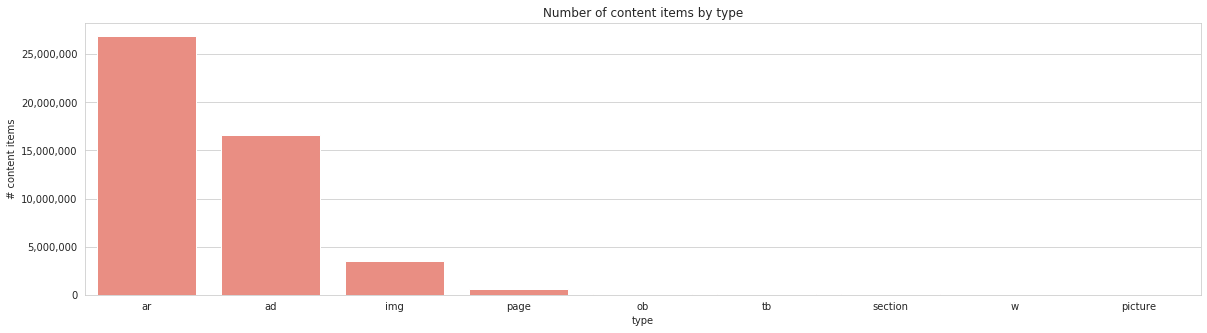

In [28]:
#Type
count_type_df = plt_freq_ci(ci_df, ['type'])

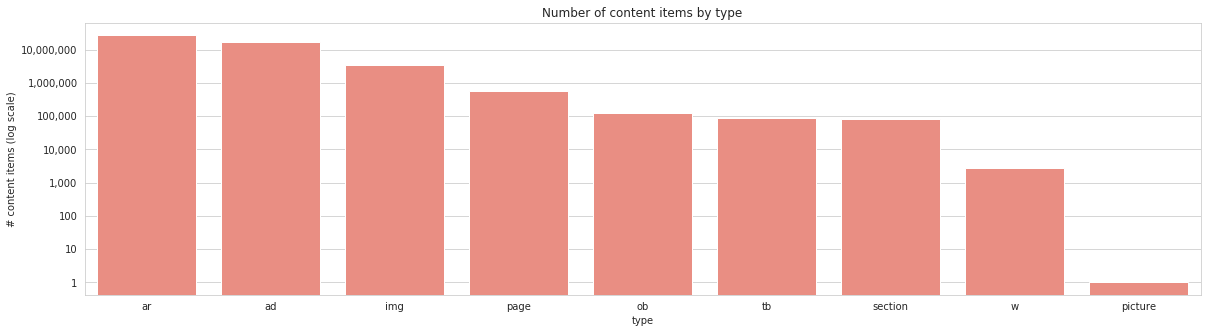

In [29]:
#Type, log scale
count_type_log_df = plt_freq_ci(ci_df, ['type'], log_y=True)

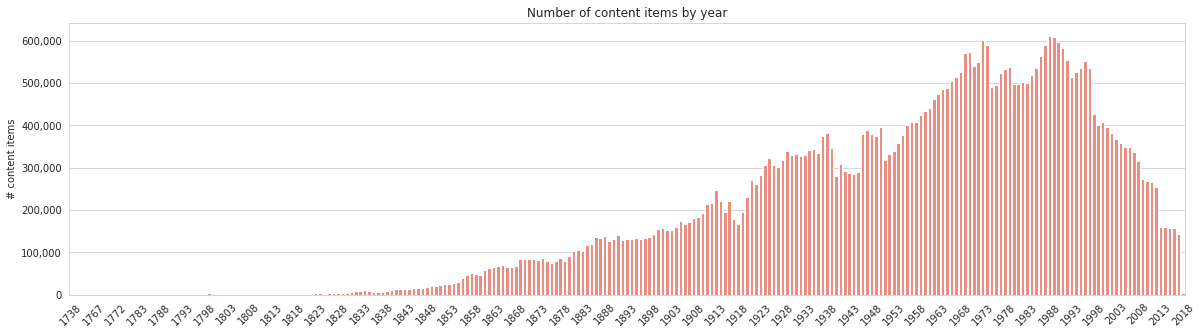

In [33]:
#Year
count_year_df = plt_freq_ci(ci_df, ['year'], hide_xtitle=True)

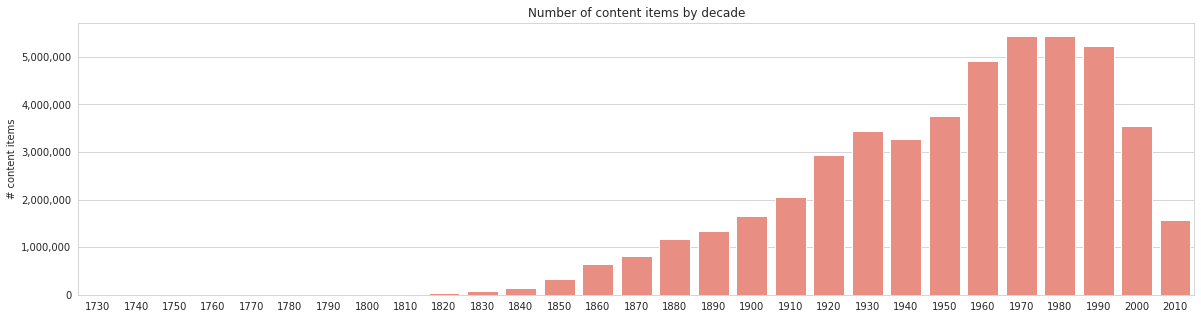

In [34]:
#Decade
count_decade_df = plt_freq_ci(ci_df, ['decade'], hide_xtitle=True)

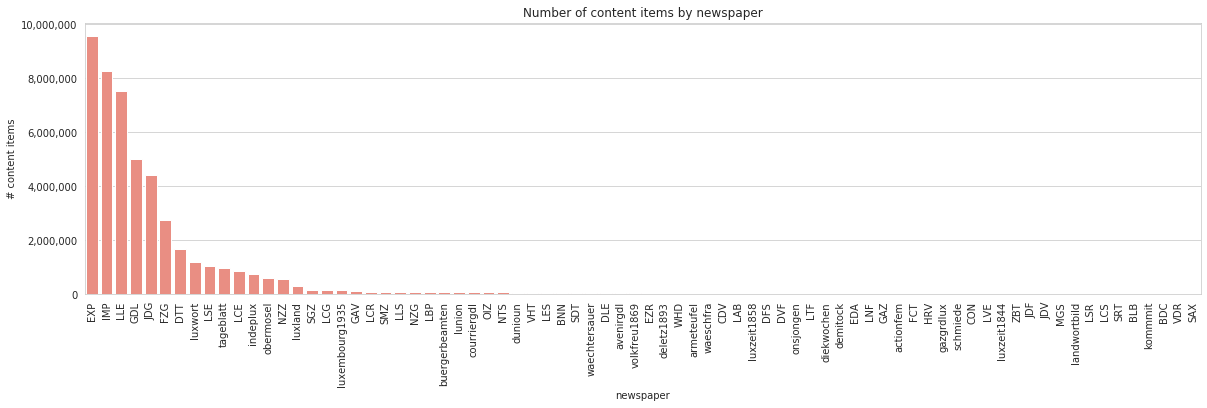

In [35]:
#Newspaper
count_np_df = plt_freq_ci(ci_df, ['newspaper'])

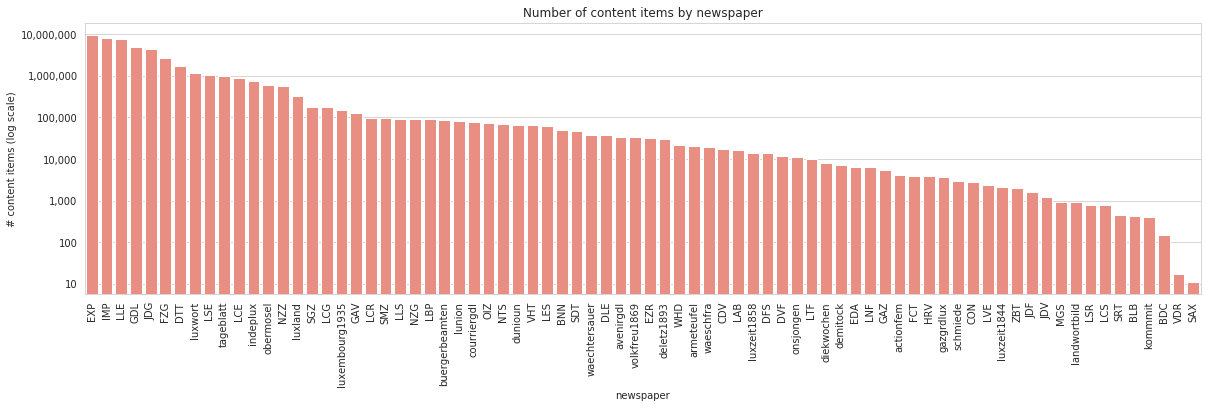

In [36]:
#Newspaper logarithmic scale
count_np_log_df = plt_freq_ci(ci_df, ['newspaper'], log_y=True)

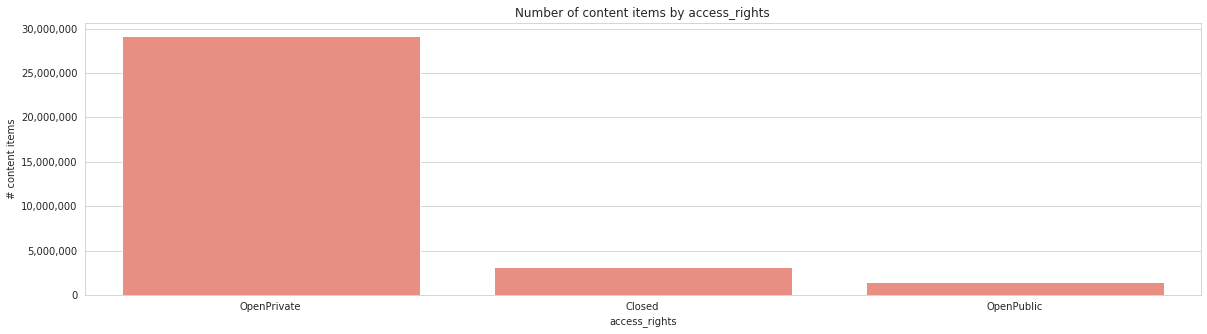

In [37]:
# Licenses
count_licenses_df = plt_freq_ci(ci_licences_df, ['access_rights'])

---

#### By type of content item

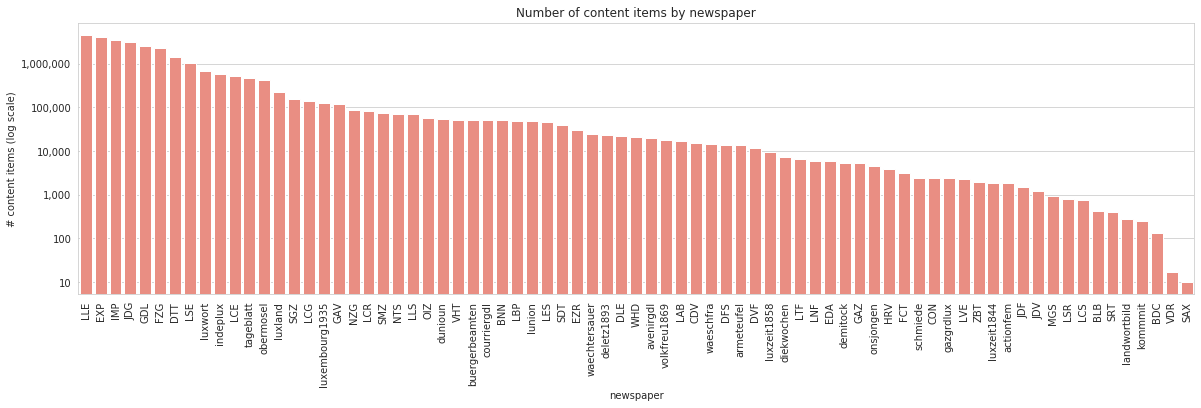

In [40]:
count_ar_np_df = plt_freq_ci_filter(ci_df, ['newspaper'], types=['ar'], log_y=True)

---

## 2D function

When plotting in 2D, filtering becomes necessary in order to avoid having too much data to plot on a single graph (the limit is set to a total of 350 bars for now). You can change it in the file `visualization.py`.

For example, if you wish to plot the number of content items per newspaper by year, you will need to select some newspapers (we recommend 2 or 3, until 5 maximum), and eventually some year bounds.

In [ ]:
count_year_np_df = plt_freq_ci_filter(ci_df, ['year', 'newspaper'], np_ids=['GDL', 'JDG'])

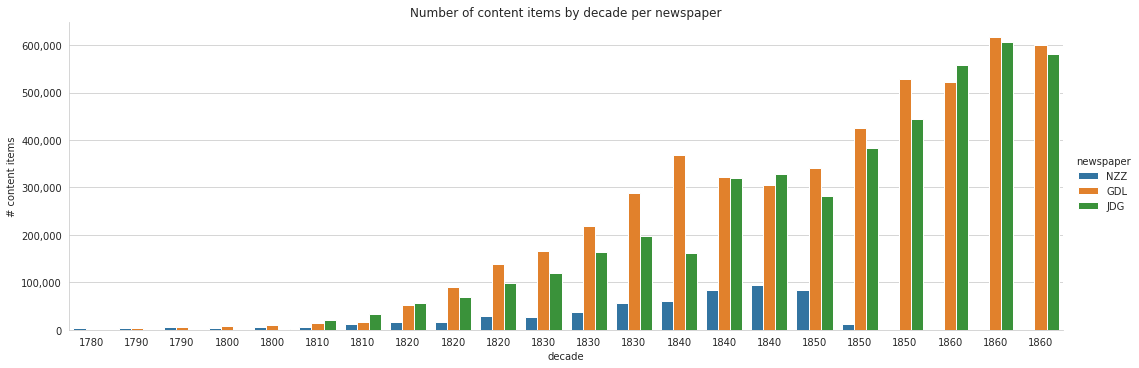

In [45]:
count_decade_np_df = plt_freq_ci_filter(ci_df, ['decade', 'newspaper'], np_ids=['NZZ', 'JDG', 'GDL'])

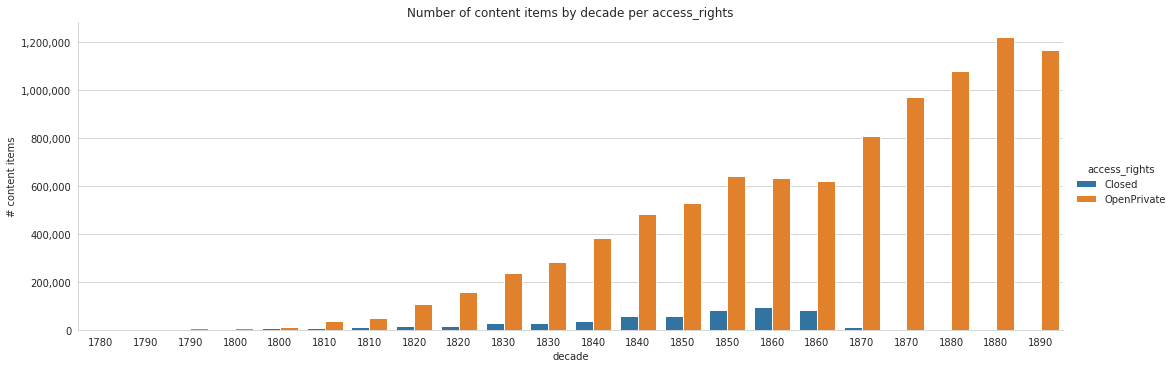

In [87]:
count_decade_licences_df = plt_freq_ci_filter(ci_licences_df, \
                                              ['decade', 'access_rights'], \
                                              np_ids=['NZZ', 'JDG', 'GDL'])

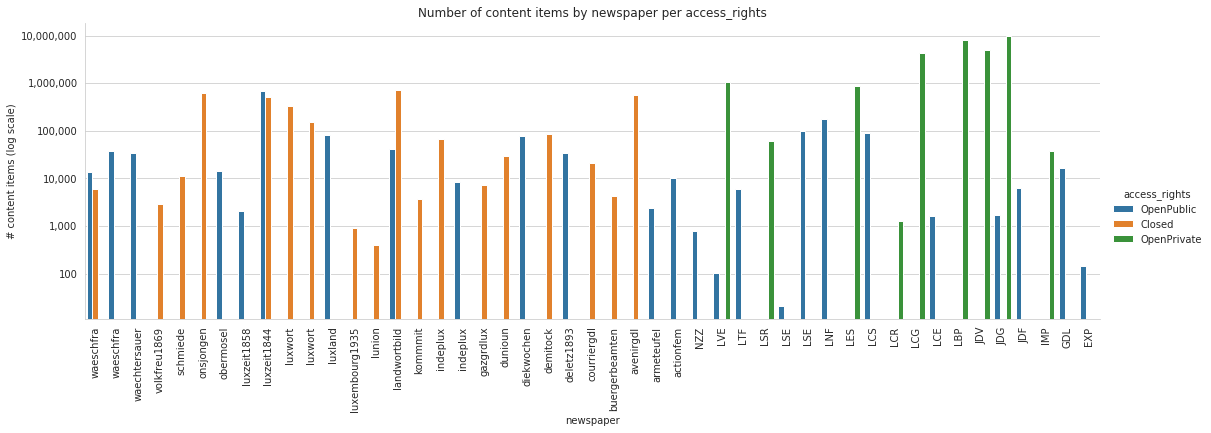

In [88]:
count_np_licences_df = plt_freq_ci_filter(ci_licences_df,['newspaper', 'access_rights'],log_y=True)

---

#### By type of content item

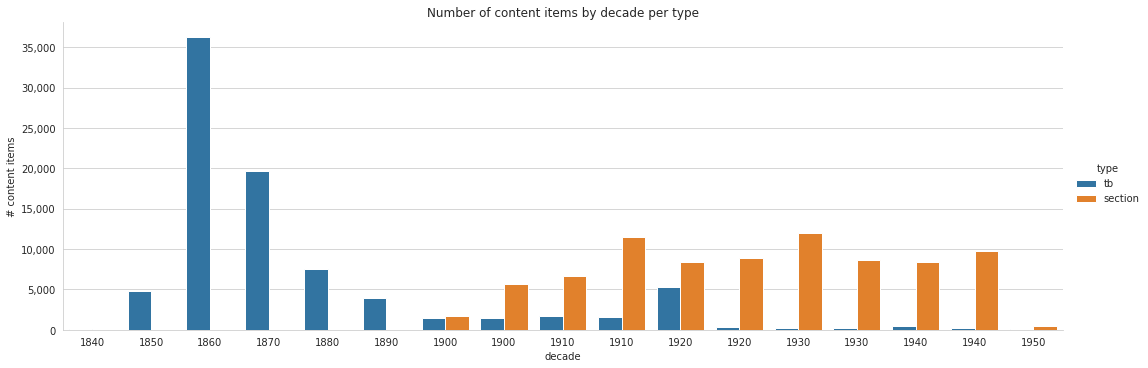

In [50]:
count_decade_type_df = plt_freq_ci_filter(ci_df, ['decade', 'type'], types=['section', 'tb'])

---

### Title length stats

Ideas
- avg title length per np / per year
- box plot ? (if 1 year / 1 np specified : yes) else just avg (+ CI ?)


In [ ]:
ci_df.head()